In [9]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import glob
from tqdm import tqdm
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers, Input, models, layers, metrics
import shutil
import cv2
import matplotlib.image as mping
from tensorflow.keras.models import Sequential

In [92]:
class CFG:
    img_size = 128
    channels = 3

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    except:
        pass

def pickleIO(obj, src, op="r"):
    if op=="w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op=="r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj
    
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)

def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]

def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

## 데이터 프레임 만들어 놓기

In [93]:
df = pd.DataFrame()
df["file_path"] = glob.glob(r"./plant-pathology-2020-fgvc7//images/*")
df["file_name"] = df["file_path"].apply(lambda x: x.split("\\")[-1])
df["img_idx"] = df["file_name"].apply(lambda x: x.split("_")[-1].split(".")[0]).astype("int64")
df["type"] = df["file_name"].apply(lambda x: x.split("_")[0])
df["ext"] = df["file_name"].apply(lambda x: x.split(".")[-1])

### train test로 나누기 및 train.csv에 healthy, multiple_diseases, rust, scab 추가

In [94]:
df_full = df[df["type"] == "Train"].sort_values("img_idx").reset_index(drop=True)
df_full_labels = pd.read_csv("./plant-pathology-2020-fgvc7/train.csv").rename(columns={"image_id": "file_name"})
df_full_labels["file_name"] = df_full_labels["file_name"].apply(lambda x: x + ".jpg")
df_full = df_full.merge(df_full_labels, how="left", on="file_name")

# test
df_test = df[df["type"] == "Test"].sort_values("img_idx").reset_index(drop=True)

In [98]:

stratVec = df_full["healthy"].astype("str") + "_" + \
    df_full["multiple_diseases"].astype("str") + "_" + \
    df_full["rust"].astype("str") + "_" + \
    df_full["scab"].astype("str")

df_train, df_valid = train_test_split(df_full, test_size=0.2, stratify=stratVec, shuffle=True, random_state=42)

### 피클로 저장해놓기


In [41]:
pickleIO(df_full, "./plant-pathology-2020-fgvc7/df_full.pkl", "w")
pickleIO(df_test, "./plant-pathology-2020-fgvc7/df_test.pkl", "w")

In [43]:
pickleIO(df_train.reset_index(drop=True), "./plant-pathology-2020-fgvc7/df_train.pkl", "w")
pickleIO(df_valid.reset_index(drop=True), "./plant-pathology-2020-fgvc7/df_valid.pkl", "w")

### train_image , test_image 파일만들어서 사진들 구분해서 놓기

In [95]:

save_all_train = "./plant-pathology-2020-fgvc7/train_images"
save_all_test = './plant-pathology-2020-fgvc7/test_images'
if not os.path.exists(save_all_train):
    os.makedirs(save_all_train, exist_ok=True)
    os.makedirs(save_all_test, exist_ok=True)
    # df_train 이미지 전체
    for img_path in df_full["file_path"]:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(save_all_train, img_name)
        shutil.copy(img_path, save_path)

    # df_test 이미지 전체
    for img_path in df_test["file_path"]:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(save_all_test, img_name)
        shutil.copy(img_path, save_path)

### train 이미지에서 또 다시 train이랑 valid으로 나누기


In [130]:
save_dir_train = "./plant-pathology-2020-fgvc7/train_train"
save_dir_valid = "./plant-pathology-2020-fgvc7/train_valid"


# 폴더 생성
if not os.path.exists(save_dir_train):
    os.makedirs(save_dir_train, exist_ok=True)
    os.makedirs(save_dir_valid, exist_ok=True)

    # df_train_train 이미지 저장
    for img_path in df_train["file_path"]:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(save_dir_train, img_name)
        shutil.copy(img_path, save_path)

    # # df_train_valid 이미지 저장
    for img_path in df_valid["file_path"]:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(save_dir_valid, img_name)
        shutil.copy(img_path, save_path)

### 이미지 크기 바꾸기

In [103]:
    # train_train_resized_path = "./plant-pathology-2020-fgvc7/train_train_images_resized"
# train_valid_resized_path = "./plant-pathology-2020-fgvc7/train_valid_images_resized"
# if not os.path.exists(train_train_resized_path):
#     os.makedirs(train_train_resized_path, exist_ok=True)
#     os.makedirs(train_valid_resized_path, exist_ok=True)

#     for path, name in tqdm(zip(df_train["file_path"], df_train["file_name"])):
#         img = cv2.imread(path)
#         img = cv2.resize(img, dsize=(CFG.img_size, CFG.img_size), interpolation=cv2.INTER_LINEAR)
#         cv2.imwrite(f"{train_train_resized_path}/{name}", img)

#     for path, name in tqdm(zip(df_valid["file_path"], df_valid["file_name"])):
#         img = cv2.imread(path)
#         img = cv2.resize(img, dsize=(CFG.img_size, CFG.img_size), interpolation=cv2.INTER_LINEAR)
#         cv2.imwrite(f"/{train_valid_resized_path}/{name}", img)

1456it [00:25, 56.45it/s]
365it [00:06, 59.06it/s]


In [118]:
train_train_list =[]
for path in df_train["file_path"]:
    img = plt.imread(path)
    train_train_list.append(img)

train_valid_list =[]
for path in df_valid["file_path"]:
    img = plt.imread(path)
    train_valid_list.append(img)

### 이미지를 증식 시키기 위해서 crossentropy이기 때문에 클래스를 만들기 위해서 이렇게 나눴다.

In [144]:
df_train_healthy =df_train[df_train['healthy']==1]
df_train_multiple_diseases =df_train[df_train['multiple_diseases']==1]
df_train_rust =df_train[df_train['rust']==1]
df_train_scab =df_train[df_train['scab']==1]

df_valid_healthy =df_valid[df_valid['healthy']==1]
df_valid_multiple_diseases =df_valid[df_valid['multiple_diseases']==1]
df_valid_rust =df_valid[df_valid['rust']==1]
df_valid_scab =df_valid[df_valid['scab']==1]

In [203]:
df_train

,file_path,file_name,img_idx,type,ext,healthy,multiple_diseases,rust,scab
816,./plant-pathology-2020-fgvc7//images\Train_816...,Train_816.jpg,816,Train,jpg,0,0,1,0
727,./plant-pathology-2020-fgvc7//images\Train_727...,Train_727.jpg,727,Train,jpg,0,0,0,1
928,./plant-pathology-2020-fgvc7//images\Train_928...,Train_928.jpg,928,Train,jpg,0,0,1,0
1725,./plant-pathology-2020-fgvc7//images\Train_172...,Train_1725.jpg,1725,Train,jpg,0,0,1,0
155,./plant-pathology-2020-fgvc7//images\Train_155...,Train_155.jpg,155,Train,jpg,0,0,0,1
...,...,...,...,...,...,...,...,...,...
956,./plant-pathology-2020-fgvc7//images\Train_956...,Train_956.jpg,956,Train,jpg,1,0,0,0
560,./plant-pathology-2020-fgvc7//images\Train_560...,Train_560.jpg,560,Train,jpg,0,0,1,0
356,./plant-pathology-2020-fgvc7//images\Train_356...,Train_356.jpg,356,Train,jpg,1,0,0,0
557,./plant-pathology-2020-fgvc7//images\Train_557...,Train_557.jpg,557,Train,jpg,0,0,1,0


### train_train_ 파일 클래스를 위한 만들기

In [154]:

df_train_train_healthy_path = './plant-pathology-2020-fgvc7/train_train/healthy'
if not os.path.exists(df_train_train_healthy_path):
    os.makedirs(df_train_train_healthy_path, exist_ok=True)

    for img_path in df_train_healthy['file_path']:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(df_train_train_healthy_path, img_name)
        shutil.copy(img_path, save_path)


    df_train_train_multiple_diseases_path = './plant-pathology-2020-fgvc7/train_train/multiple_diseases'
    os.makedirs(df_train_train_multiple_diseases_path, exist_ok=True)
    for img_path in df_train_multiple_diseases['file_path']:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(df_train_train_multiple_diseases_path, img_name)
        shutil.copy(img_path, save_path)


    df_train_train_rust_path = './plant-pathology-2020-fgvc7/train_train/rust'
    os.makedirs(df_train_train_rust_path, exist_ok=True)

    for img_path in df_train_rust['file_path']:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(df_train_train_rust_path, img_name)
        shutil.copy(img_path, save_path)

    df_train_train_scab_path = './plant-pathology-2020-fgvc7/train_train/scab'
    os.makedirs(df_train_train_scab_path, exist_ok=True)

    for img_path in df_train_scab['file_path']:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(df_train_train_scab_path, img_name)
        shutil.copy(img_path, save_path)



### train_valid_ 파일 클래스를 위한 만들기

In [158]:

df_train_valid_healthy_path = './plant-pathology-2020-fgvc7/train_valid/healthy'

if not os.path.exists(df_train_valid_healthy_path):
    os.makedirs(df_train_valid_healthy_path, exist_ok=True)

    for img_path in df_valid_healthy['file_path']:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(df_train_valid_healthy_path, img_name)
        shutil.copy(img_path, save_path)


    df_train_valid_multiple_diseases_path = './plant-pathology-2020-fgvc7/train_valid/muliple_diseases/'
    os.makedirs(df_train_valid_multiple_diseases_path, exist_ok=True)

    for img_path in df_valid_multiple_diseases['file_path']:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(df_train_valid_multiple_diseases_path, img_name)
        shutil.copy(img_path, save_path)

    df_train_valid_rust_path = './plant-pathology-2020-fgvc7/train_valid/rust'
    os.makedirs(df_train_valid_rust_path, exist_ok=True)

    for img_path in df_valid_rust['file_path']:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(df_train_valid_rust_path, img_name)
        shutil.copy(img_path, save_path)

    df_train_valid_scab_path = './plant-pathology-2020-fgvc7/train_valid/scab'
    os.makedirs(df_train_valid_scab_path, exist_ok=True)

    for img_path in df_valid_scab['file_path']:
        img_name = os.path.basename(img_path)
        save_path = os.path.join(df_train_valid_scab_path, img_name)
        shutil.copy(img_path, save_path)



In [186]:
train_train_list[0].shape

(1365, 2048, 3)

In [24]:

train_datagen= ImageDataGenerator(rescale= 1./255,
                   # 주어진 이미지 크기 설정(0~1 설정)
                   horizontal_flip = True,
                   # 수평 대칭 이미지를 50% 확률로 만들어 추가
                   # 수평으로 뒤집어줌
                   vertical_flip=True,
                   rotation_range = 5,
                   shear_range=0.7,
                   
                   # 수직으로 뒤집어줌
                   width_shift_range=0.1,
                   fill_mode='nearest')

In [25]:
train_generator = train_datagen.flow_from_directory(
                './plant-pathology-2020-fgvc7/train_train',
                target_size = (512,512),
                batch_size = 5,
                class_mode = 'categorical'
            )

Found 1456 images belonging to 4 classes.


In [26]:
# 테스트 데이터 셋을 이미지 증식 설정 안함 (매우 중요)
test_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
test_generator = test_datagen.flow_from_directory(
                  './plant-pathology-2020-fgvc7/train_valid',
                  target_size = (512,512),
                  batch_size = 5,
                  class_mode='categorical'
              )

Found 365 images belonging to 4 classes.


In [28]:

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(512,512,3)))
# channel >> 1: 흑백, 3: 컬러(R,G,B)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
    

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 1363, 2046, 32)    896       
                                                                 
 activation_10 (Activation)  (None, 1363, 2046, 32)    0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 681, 1023, 32)    0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 679, 1021, 64)     18496     
                                                                 
 activation_11 (Activation)  (None, 679, 1021, 64)     0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 339, 510, 64)     0         
 g2D)                                                 

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0002),
              metrics=['accuracy']
              )

# 학습 조기 중단
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

### train_train이랑 train_valid으로 모델 학습시키기

In [30]:
# 모델 실행
history = model.fit(
    train_generator,
    epochs=100,
    validation_data = test_generator,
    validation_steps =10,
    callbacks=[early_stopping_callback]
)

# validation_steps = 10 >> 검증데이터 셋 에서 10개의 배치 사용, 검증 과정 수행함

Epoch 1/100
728/728 [==============================] - ETA: 0s - loss: 1.2974 - accuracy: 0.2981

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_2/activation_10/Relu' defined at (most recent call last):
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_19080\710692774.py", line 2, in <module>
      history = model.fit(
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1606, in fit
      val_logs = self.evaluate(
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\layers\core\activation.py", line 59, in call
      return self.activation(inputs)
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_2/activation_10/Relu'
OOM when allocating tensor with shape[5,32,1363,2046] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_2/activation_10/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_8778]

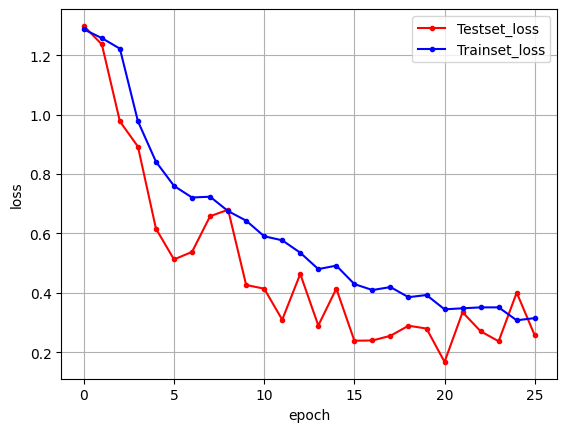

In [201]:
# 검증셋과 학습셋의 오차 저장

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [213]:
glob.glob('./plant-pathology-2020-fgvc7/test_images/*')

['./plant-pathology-2020-fgvc7/test_images\\Test_0.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_10.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_100.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1000.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1001.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1002.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1003.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1004.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1005.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1006.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1007.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1008.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1009.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_101.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1010.jpg',
 './plant-pathology-2020-fgvc7/test_images\\Test_1

In [215]:
df_test

,file_path,file_name,img_idx,type,ext
0,./plant-pathology-2020-fgvc7//images\Test_0.jpg,Test_0.jpg,0,Test,jpg
1,./plant-pathology-2020-fgvc7//images\Test_1.jpg,Test_1.jpg,1,Test,jpg
2,./plant-pathology-2020-fgvc7//images\Test_2.jpg,Test_2.jpg,2,Test,jpg
3,./plant-pathology-2020-fgvc7//images\Test_3.jpg,Test_3.jpg,3,Test,jpg
4,./plant-pathology-2020-fgvc7//images\Test_4.jpg,Test_4.jpg,4,Test,jpg
...,...,...,...,...,...
1816,./plant-pathology-2020-fgvc7//images\Test_1816...,Test_1816.jpg,1816,Test,jpg
1817,./plant-pathology-2020-fgvc7//images\Test_1817...,Test_1817.jpg,1817,Test,jpg
1818,./plant-pathology-2020-fgvc7//images\Test_1818...,Test_1818.jpg,1818,Test,jpg
1819,./plant-pathology-2020-fgvc7//images\Test_1819...,Test_1819.jpg,1819,Test,jpg


In [225]:
test_list = []
for path in df_test["file_path"]:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR을 RGB로 변경
    img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_LINEAR).astype('float32')
    img = img / 255.0  # 이미지를 255로 나누기
    test_list.append(img)


In [229]:
test_list[0].shape

(512, 512, 3)

In [230]:
df_

,file_path,file_name,img_idx,type,ext,healthy,multiple_diseases,rust,scab
816,./plant-pathology-2020-fgvc7//images\Train_816...,Train_816.jpg,816,Train,jpg,0,0,1,0
727,./plant-pathology-2020-fgvc7//images\Train_727...,Train_727.jpg,727,Train,jpg,0,0,0,1
928,./plant-pathology-2020-fgvc7//images\Train_928...,Train_928.jpg,928,Train,jpg,0,0,1,0
1725,./plant-pathology-2020-fgvc7//images\Train_172...,Train_1725.jpg,1725,Train,jpg,0,0,1,0
155,./plant-pathology-2020-fgvc7//images\Train_155...,Train_155.jpg,155,Train,jpg,0,0,0,1
...,...,...,...,...,...,...,...,...,...
956,./plant-pathology-2020-fgvc7//images\Train_956...,Train_956.jpg,956,Train,jpg,1,0,0,0
560,./plant-pathology-2020-fgvc7//images\Train_560...,Train_560.jpg,560,Train,jpg,0,0,1,0
356,./plant-pathology-2020-fgvc7//images\Train_356...,Train_356.jpg,356,Train,jpg,1,0,0,0
557,./plant-pathology-2020-fgvc7//images\Train_557...,Train_557.jpg,557,Train,jpg,0,0,1,0
